In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar  9 15:25:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Transfer learning

In [ ]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.layers import Dropout
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
train = '/content/drive/MyDrive/Datasets/Eyes'
test = '/content/drive/MyDrive/Datasets/Eyes_test'
# the dataset used is available at https://www.kaggle.com/code/adinishad/driver-drowsiness-using-keras/data
# the above link contains dataset wit 4 classes which was reduced to two classed with folders closed and open
# part of data was used to create test set separate from the validation set.

In [ ]:
train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

#test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

BATCH_SIZE = 64

traingen = train_generator.flow_from_directory(train,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)




Found 1244 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


In [ ]:
testgen = train_generator.flow_from_directory(test,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=1, 
                                               shuffle=True,
                                               seed=42)

Found 532 images belonging to 2 classes.


## VGG 16

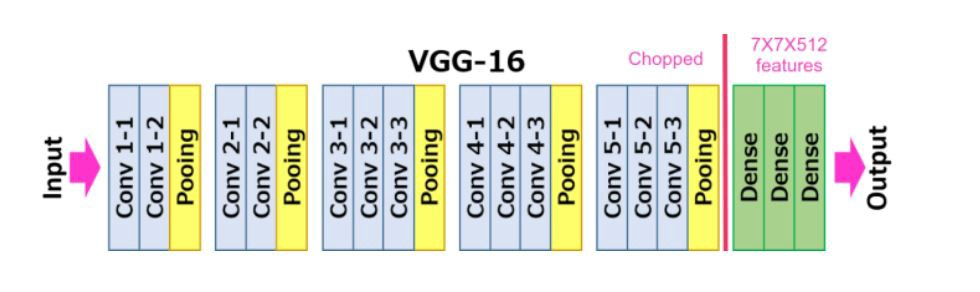

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
model = create_model((224,224,3), 2, optimizer='rmsprop', fine_tune=0)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
es = EarlyStopping(patience = 10, min_delta = 0.001, monitor = 'accuracy' )
hist = model.fit(traingen, steps_per_epoch=20, epochs=100, validation_data=validgen, callbacks = es)

Epoch 1/100
20/20 [==============================] - 195s 10s/step - loss: 122.6744 - accuracy: 0.7540 - val_loss: 0.1898 - val_accuracy: 0.9404
Epoch 2/100
20/20 [==============================] - 26s 1s/step - loss: 0.2311 - accuracy: 0.9293 - val_loss: 0.3849 - val_accuracy: 0.9083
Epoch 3/100
20/20 [==============================] - 26s 1s/step - loss: 0.6667 - accuracy: 0.8818 - val_loss: 0.2986 - val_accuracy: 0.9174
Epoch 4/100
20/20 [==============================] - 25s 1s/step - loss: 0.3398 - accuracy: 0.9164 - val_loss: 0.9731 - val_accuracy: 0.8532
Epoch 5/100
20/20 [==============================] - 26s 1s/step - loss: 0.5514 - accuracy: 0.8995 - val_loss: 1.1569 - val_accuracy: 0.8807
Epoch 6/100
20/20 [==============================] - 25s 1s/step - loss: 0.1800 - accuracy: 0.9502 - val_loss: 0.2909 - val_accuracy: 0.9266
Epoch 7/100
20/20 [==============================] - 26s 1s/step - loss: 0.2710 - accuracy: 0.9260 - val_loss: 1.0148 - val_accuracy: 0.7202
Epoch 8/1

In [ ]:
_, acc = model.evaluate(testgen)
print(acc)

532/532 [==============================] - 88s 165ms/step - loss: 0.0799 - accuracy: 0.9774
0.9774436354637146


In [ ]:
from matplotlib import pyplot
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	pyplot.show()

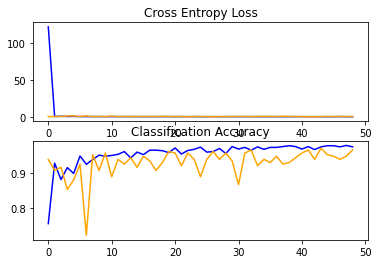

In [ ]:
summarize_diagnostics(hist)

In [ ]:
model.save('/content/gdrive/My Drive/minor_project_model.h5')

## InceptionV3


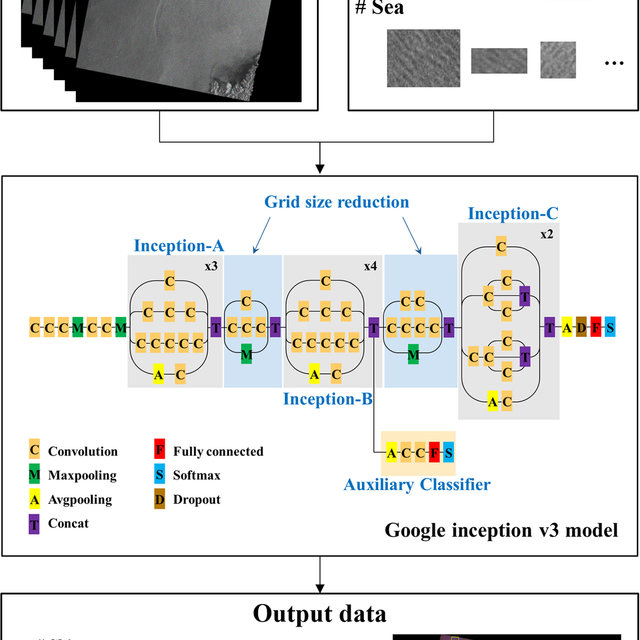

In [ ]:
from keras.applications.inception_v3 import preprocess_input as pi

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=pi) # Inception preprocessing

#test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

BATCH_SIZE = 64

traingen = train_generator.flow_from_directory(train,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = train_generator.flow_from_directory(test,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=1, 
                                               shuffle=True,
                                               seed=42)

Found 1244 images belonging to 2 classes.
Found 218 images belonging to 2 classes.
Found 532 images belonging to 2 classes.


In [ ]:
from keras.applications.inception_v3 import InceptionV3
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False,
                                                      input_shape=(224, 224, 3))

In [ ]:
for layer in InceptionV3_model.layers[:]:
    layer.trainable = False

x = InceptionV3_model.output
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=2, activation='softmax')(x)
model = Model(InceptionV3_model.input, output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [ ]:
es = EarlyStopping(patience = 10, min_delta = 0.001, monitor = 'accuracy' )
hist = model.fit(traingen, steps_per_epoch=20, epochs=100, validation_data=validgen, callbacks = es)

Epoch 1/100
20/20 [==============================] - 34s 2s/step - loss: 7.6284 - accuracy: 0.5844 - val_loss: 0.5727 - val_accuracy: 0.7064
Epoch 2/100
20/20 [==============================] - 25s 1s/step - loss: 0.8377 - accuracy: 0.6318 - val_loss: 0.4584 - val_accuracy: 0.7936
Epoch 3/100
20/20 [==============================] - 27s 1s/step - loss: 0.6912 - accuracy: 0.7074 - val_loss: 1.6106 - val_accuracy: 0.6009
Epoch 4/100
20/20 [==============================] - 24s 1s/step - loss: 0.6781 - accuracy: 0.6969 - val_loss: 0.3145 - val_accuracy: 0.8578
Epoch 5/100
20/20 [==============================] - 24s 1s/step - loss: 0.4671 - accuracy: 0.7789 - val_loss: 0.6598 - val_accuracy: 0.7248
Epoch 6/100
20/20 [==============================] - 25s 1s/step - loss: 0.6048 - accuracy: 0.7661 - val_loss: 0.3747 - val_accuracy: 0.8073
Epoch 7/100
20/20 [==============================] - 24s 1s/step - loss: 0.3559 - accuracy: 0.8473 - val_loss: 0.3554 - val_accuracy: 0.8440
Epoch 8/100
2

In [ ]:
_, acc = model.evaluate(testgen)
print(acc)

532/532 [==============================] - 311s 584ms/step - loss: 0.1824 - accuracy: 0.9305
0.9304511547088623


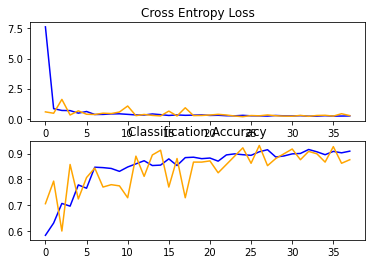

In [ ]:
summarize_diagnostics(hist)